# Predicting Gentrification using Machine Learning
#### Forecasting the Neighborhood Change and Detecting Gentrification with Yelp Data

**Data Source:**
<br>
Rent data - median studio price by zipcode *downloaded from zillow 
<br>
Yelp data - Yelp API

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
# import seaborn as sns
# import statsmodels.formula.api as smf
# from scipy import stats
# from bokeh.layouts import column, row, widgetbox
# from bokeh.models import CustomJS, Slider, Toggle
# from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LogTicker, ColorBar
# from bokeh.plotting import figure, show, output_file, ColumnDataSource
# from bokeh.io import push_notebook, output_notebook
# from ipywidgets import *
# import ipywidgets as widgets
# from shapely.geometry import Point, Polygon,MultiPoint, MultiPolygon
warnings.filterwarnings("ignore")
# %matplotlib inline

#### We will use machine learning algorithm to detect if the area is:
    -  **Gentrifying**: the area that was low-income in 1990 and experienced rent growth above the median SBA rent growth between 1990 and 2010-2014
    - **Non-gentrifying**: the areas that started off as low-income in 1990 but experienced more modest growth
    - **Higher-income**: the areas that had higher incomes in 1990.

In [4]:
!pip install imblearn
# --user option

**We've only looked at Williamsburg, and Bushwick, but can we generalize it to the whole NYC area?** <br> <br>
Using machine learning algorithm to detect if the area is: <br>
**Gentrifying:** the area that was low-income in 1990 and experienced rent growth above the median SBA rent growth between 1990 and 2010-2014 <br>
**Non-gentrifying:** the areas that started off as low-income in 1990 but experienced more modest growth <br>
**Higher-income:** the areas that had higher incomes in 1990. <br>
for this, some of yelp data are combined with demographic data from 2016 Census <br> <br>
Source: http://furmancenter.org/files/sotc/Part_1_Gentrification_SOCin2015_9JUNE2016.pdf

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from textwrap import wrap

In [16]:
zipcode_neighborhood_df_test_exc_income = pd.read_csv('zipcode_neighborhood_df_test_exc_income.csv', index_col = 0)
zipcode_neighborhood_df_test_exc_income=zipcode_neighborhood_df_test_exc_income.reset_index() #re-indexing
zipcode_neighborhood_df_test_exc_income= zipcode_neighborhood_df_test_exc_income.iloc[:,2:] #removing old index
zipcode_neighborhood_df_test_exc_income.head()

,zipcodes,gentrification_label,avg_rating,avg_price,starbucks_count,bars,"%, Less than 9th grade","%, 9th to 12th grade, no diploma",% High school graduate (includes equivalency),"% Some college, no degree",...,% Graduate or professional degree,% high school graduate or higher,% bachelor's degree or higher,% White,% African American,% American Indian and Alaska Native,% Asian,% Native Hawaiian and Other Pacific Islander,% Some other race,cafe_count
0,10453,1,3.412022,1.446834,0.0,0.0,17.2,16.3,29.0,16.7,...,3.2,66.6,13.2,10.4,32.0,0.8,1.5,0.1,52.8,3.0
1,10457,2,3.175676,1.231801,0.0,0.0,18.7,18.6,26.2,18.1,...,4.4,62.7,12.8,11.6,34.5,0.4,1.3,0.1,48.8,2.0
2,10460,2,3.477435,1.406593,0.0,0.0,18.2,20.5,25.8,17.8,...,2.6,61.3,12.1,13.4,28.5,0.2,1.6,0.0,53.6,1.0
3,10458,1,3.774120,1.461673,2.0,3.0,16.2,15.5,29.4,18.4,...,4.1,68.3,13.9,19.3,20.5,0.4,3.1,0.1,52.2,15.0
4,10467,1,3.546569,1.274436,0.0,1.0,14.0,14.0,29.1,17.0,...,6.0,72.0,19.0,20.0,35.7,0.7,6.3,0.0,33.3,8.0


In [17]:
# len(zipcode_neighborhood_df_test_exc_income['gentrification_label']==0)
# zipcode_neighborhood_df_test_exc_income[zipcode_neighborhood_df_test_exc_income['zipcodes']==10002]
## 0 - high income
## 2 - getrifying
sum(zipcode_neighborhood_df_test_exc_income['gentrification_label']==0)/157 ## high income 68%
sum(zipcode_neighborhood_df_test_exc_income['gentrification_label']==1)/157 ## Non-gentrifying 7%
sum(zipcode_neighborhood_df_test_exc_income['gentrification_label']==2)/157 ## Gentrifying 25%

0.2484076433121019

In [19]:
X = zipcode_neighborhood_df_test_exc_income.loc[:,'avg_rating':]
target = zipcode_neighborhood_df_test_exc_income['gentrification_label']
X = X.replace('-', 0)
X.head()

,avg_rating,avg_price,starbucks_count,bars,"%, Less than 9th grade","%, 9th to 12th grade, no diploma",% High school graduate (includes equivalency),"% Some college, no degree",% A Associate's degree,% Bachelor's degree,% Graduate or professional degree,% high school graduate or higher,% bachelor's degree or higher,% White,% African American,% American Indian and Alaska Native,% Asian,% Native Hawaiian and Other Pacific Islander,% Some other race,cafe_count
0,3.412022,1.446834,0.0,0.0,17.2,16.3,29.0,16.7,7.5,10.1,3.2,66.6,13.2,10.4,32.0,0.8,1.5,0.1,52.8,3.0
1,3.175676,1.231801,0.0,0.0,18.7,18.6,26.2,18.1,5.6,8.4,4.4,62.7,12.8,11.6,34.5,0.4,1.3,0.1,48.8,2.0
2,3.477435,1.406593,0.0,0.0,18.2,20.5,25.8,17.8,5.6,9.5,2.6,61.3,12.1,13.4,28.5,0.2,1.6,0.0,53.6,1.0
3,3.774120,1.461673,2.0,3.0,16.2,15.5,29.4,18.4,6.6,9.9,4.1,68.3,13.9,19.3,20.5,0.4,3.1,0.1,52.2,15.0
4,3.546569,1.274436,0.0,1.0,14.0,14.0,29.1,17.0,6.8,12.9,6.0,72.0,19.0,20.0,35.7,0.7,6.3,0.0,33.3,8.0


### Random Forest Classifier

In [20]:
%matplotlib inline
data_train, data_test, target_train, target_test = train_test_split(X, target)
forest= RandomForestClassifier(n_estimators= 40, max_depth= 5)
forest.fit(data_train, target_train)
feature_importances = forest.feature_importances_
feature_importance_list = [round(value, 4) for value in feature_importances]

feature_importance = dict(zip(X.columns, feature_importance_list))
print('\n', 'Top 10 Features:')
sorted_dict = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict[:10]:
    print(item)
kfold_scores_forest = cross_val_score(forest, X, target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (kfold_scores_forest.mean()*100, kfold_scores_forest.std() * 2*100))


 Top 10 Features:
('%, 9th to 12th grade, no diploma', 0.1247)
("% A Associate's degree", 0.1045)
('%, Less than 9th grade', 0.097)
('% high school graduate or higher', 0.0722)
("% bachelor's degree or higher", 0.0606)
("% Bachelor's degree", 0.0579)
('% Asian', 0.0557)
('avg_rating', 0.0536)
('% Some other race', 0.0531)
('% White', 0.0502)
Accuracy: 72.76 (+/- 12.54)


In [21]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Binarize the output
y = label_binarize(target, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
# n_samples, n_features = X.shape
# X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X, y, test_size=.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators= 40, max_depth= 5))
y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(list(y_test_roc[:, i]), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

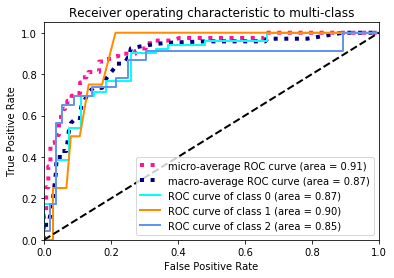

In [22]:
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [23]:
X_train_roc.shape

(78, 20)

**Logistic Regression**

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
# X_train_roc, X_test_roc, y_train_roc, y_test_roc
lrn = LogisticRegression()
lrn.fit(data_train, target_train)
y_pred = lrn.predict(data_test)
np.mean(y_pred==target_test)

0.8

**K-Nearest Neighbours**

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train, target_train)
y_pred = knn.predict(data_test)
np.mean(y_pred==target_test)

0.75

**Decision Tree**

In [38]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(data_train, target_train)
y_pred = clf.predict(data_test)
np.mean(y_pred==target_test)

0.7

**LDA**

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(data_train, target_train)

y_pred = lda.predict(data_test)
np.mean(y_pred==target_test)

0.775

In [50]:
# !pip install xgboost
# -- user requirement

**XGBoost**

In [40]:
import xgboost as xgb
gbm= xgb.XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.01).fit(data_train, target_train)
y_pred = gbm.predict(data_test)
np.mean(y_pred==target_test)

0.8

## Oversampling of Data
#### Applying the same models with oversampling to check for improved accuracies

In [41]:
# correct the class imbalance
print(target.value_counts())
X_resampled, y_resampled = SMOTE().fit_sample(X, target) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

0    107
2     39
1     11
Name: gentrification_label, dtype: int64
2    107
1    107
0    107
dtype: int64


In [42]:
%matplotlib inline
data_train, data_test, target_train, target_test = train_test_split(X_resampled, y_resampled)
forest= RandomForestClassifier(n_estimators= 40, max_depth= 5)
forest.fit(data_train, target_train)
feature_importances = forest.feature_importances_
feature_importance_list = [round(value, 4) for value in feature_importances]

feature_importance = dict(zip(X.columns, feature_importance_list))
print('\n', 'Top 10 Features:')
sorted_dict = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for item in sorted_dict[:10]:
    print(item)
kfold_scores_forest = cross_val_score(forest, X_resampled, y_resampled, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (kfold_scores_forest.mean()*100, kfold_scores_forest.std() * 2*100))


 Top 10 Features:
('%, 9th to 12th grade, no diploma', 0.0973)
("% bachelor's degree or higher", 0.0929)
('%, Less than 9th grade', 0.0866)
("% Bachelor's degree", 0.0853)
('% High school graduate (includes equivalency)', 0.0772)
('% Graduate or professional degree', 0.0733)
("% A Associate's degree", 0.0605)
('% high school graduate or higher', 0.0559)
('% African American', 0.052)
('% Some other race', 0.0404)
Accuracy: 89.45 (+/- 8.03)


In [43]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Binarize the output
y = label_binarize(y_resampled, classes=[0, 1, 2])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X_resampled, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators= 40, max_depth= 5))
y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(list(y_test_roc[:, i]), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

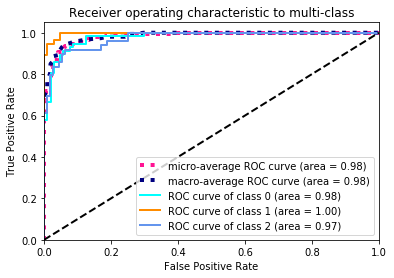

In [44]:
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**Logistic Regression**

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
# X_train_roc, X_test_roc, y_train_roc, y_test_roc
lrn = LogisticRegression()
lrn.fit(data_train, target_train)
y_pred = lrn.predict(data_test)
np.mean(y_pred==target_test)

0.8888888888888888

**K-Nearest Neighbors**

In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train, target_train)
y_pred = knn.predict(data_test)
np.mean(y_pred==target_test)

0.8395061728395061

**Decision Trees**

In [152]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(data_train, target_train)
y_pred = clf.predict(data_test)
np.mean(y_pred==target_test) #best model

0.9012345679012346

**LDA**

In [46]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(data_train, target_train)

y_pred = lda.predict(data_test)
np.mean(y_pred==target_test)

0.7530864197530864

**XGBoost**

In [48]:
import xgboost as xgb
gbm= xgb.XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.01).fit(data_train, target_train)
y_pred = gbm.predict(data_test)
np.mean(y_pred==target_test)

0.8518518518518519

## Ridge, Lasso & K-Fold Cross Validation
#### We shall apply Ridge, Lasso and K-fold CV to the models on Oversampled data

In [ ]:
## ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
## ‘saga’ and ‘liblinear’ solvers support only l1 penalties.

In [94]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV

**Logistic Regression**

In [125]:
#Cross Validation with Ridge
lrn = LogisticRegressionCV(penalty="l2",solver='sag', cv=10)
# lrn = LogisticRegression(penalty="l2",solver='sag',max_iter=5000, multi_class='multinomial')
lrn.fit(data_train, target_train)

y_pred = lrn.predict(data_test)
np.mean(y_pred==target_test)

# results= model_selection.cross_val_score(lrn, X, target, cv=10)
# print("Accuracy: %.3f%% (%.3f%%)"% (results.mean()*100.0, results.std()*100.0))


C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

0.8271604938271605

In [126]:
#Cross Validation with Lasso
lrn = LogisticRegressionCV(penalty="l1",solver='liblinear', cv=10)
lrn.fit(data_train, target_train)

y_pred = lrn.predict(data_test)
np.mean(y_pred==target_test)

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Aman\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

0.7777777777777778

The Accuracy (out-of-sample score) reduces when Cross Validation with Ridge/Lasso regression is done on Logistic model. This is because less data is remaining for the training to be done compared to just Train-Test approach.
Therefore, We will only try Ridge, Lasso with K-fold CV to our best model on oversampled data.

**Decision Trees**

In [130]:
from sklearn import tree

In [149]:
parameters = {'max_depth':range(5,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), parameters, n_jobs=4)
clf.fit(data_train, target_train)

y_pred = clf.predict(data_test)
np.mean(y_pred==target_test)

# tree_model = clf.best_estimator_
# clf.best_score_

0.8271604938271605